In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# --- Visualization Setup ---
# Set a professional style for scientific plotting
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5

# --- Helper Function: Text Output ---
def print_header(title):
    """Prints a styled header for text outputs."""
    print("\n" + "="*60)
    print(f" {title.upper()}")
    print("="*60)

# --- Core Function 1: Data Loading & Preparation ---
def load_analysis_data(summary_file="results_summary.csv"):
    """
    Loads the aggregated results and prepares derived metrics for analysis.
    """
    if not os.path.exists(summary_file):
        raise FileNotFoundError(f"The file '{summary_file}' was not found. Please run the experiment loop first.")
    
    df = pd.read_csv(summary_file)
    
    # Ensure critical columns are numeric
    numeric_cols = ['n_states', 'n_shots', 'decoherence', 'svr_fid_avg', 'mle_fid_avg']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Derived Metric: Speedup Factor (How many times faster is SVR?)
    # We add a small epsilon to avoid division by zero if time is 0
    df['speedup_factor'] = df['time_mle_per_state'] / (df['time_svr_infer_per_state'] + 1e-15)
    
    print_header("Data Loaded Successfully")
    print(f"Total Experiment Configurations: {len(df)}")
    print(f"Dataset Sizes (Rows): {df['n_states'].unique()}")
    print(f"Shot Noise Levels:    {df['n_shots'].unique()}")
    print(f"Decoherence Levels:   {df['decoherence'].unique()}")
    
    return df

def get_detailed_predictions(n_states, n_shots, decoherence, data_dir="results_data"):
    """
    Retrieves the detailed prediction file (Bloch vectors) for a specific configuration.
    Useful for Part A (Physical Compliance analysis).
    """
    # Construct filename based on the convention used in the experiment loop
    # Note: '0.1' might be saved as '0p1'
    deco_str = str(decoherence).replace('.', 'p')
    pattern = f"{data_dir}/preds_N{n_states}_S{n_shots}_D{deco_str}.csv"
    
    files = glob.glob(pattern)
    if not files:
        print(f"[Warning] No detailed file found for Config: N={n_states}, S={n_shots}, D={decoherence}")
        return None
    
    return pd.read_csv(files[0])

# --- Execution ---
# Load the summary dataframe into the global scope for subsequent functions
try:
    df_results = load_analysis_data()
except Exception as e:
    print(f"Error loading data: {e}")


 DATA LOADED SUCCESSFULLY
Total Experiment Configurations: 90
Dataset Sizes (Rows): [ 100 1000 5000]
Shot Noise Levels:    [  10   50  100  400 1000 5000]
Decoherence Levels:   [0.  0.1 0.3 0.5 0.8]


In [5]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Attempt to import the provided local module
# Assuming the file 'saint_dtSet.py' is in a folder named 'gemi' or in the root path.
try:
    from saint_dtSet import generate_qubit_tomography_dataset_base, perform_mle_tomography
except ImportError:
    # Fallback if the file is in the same directory
    try:
        from dataset_build.saint_dtSet import generate_qubit_tomography_dataset_base, perform_mle_tomography
    except ImportError:
        raise ImportError("Please ensure 'saint_dtSet.py' is in the python path.")

# ------------------------------------------------------------------------------
# METRICS DEFINITION
# ------------------------------------------------------------------------------

def bloch_to_density_matrix(x, y, z):
    """
    Converts Bloch vector components to a 2x2 density matrix.
    rho = 1/2 * (I + x*sigma_x + y*sigma_y + z*sigma_z)
    """
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    identity = np.eye(2, dtype=complex)
    
    rho = 0.5 * (identity + x*sigma_x + y*sigma_y + z*sigma_z)
    return rho


def calculate_purity(row, cols=('X_real', 'Y_real', 'Z_real')):
    """
    Calcule la pureté d'un état quantique à partir de son vecteur de Bloch.
    Formule : Purity = Tr(rho^2) = 1/2 * (1 + |r|^2)
    
    Retourne :
    - 1.0 si l'état est Pur (|r|=1)
    - 0.5 si l'état est Maximale Mixte (|r|=0)
    """
    # Extrait le vecteur [x, y, z]
    r_vec = np.array([row[c] for c in cols])
    
    # Calcule la norme au carré |r|^2 = x^2 + y^2 + z^2
    r_squared = np.dot(r_vec, r_vec)
    
    # Formule de la pureté
    return 0.5 * (1 + r_squared)
def calculate_fidelity(row, pred_cols=('X_pred', 'Y_pred', 'Z_pred'), real_cols=('X_real', 'Y_real', 'Z_real')):
    """
    Calculates the quantum fidelity between the Real state and the Predicted state.
    
    Formula for single qubit using Bloch vectors r_real and r_pred:
    F(rho, sigma) = 0.5 * (1 + r_real.r_pred + sqrt((1 - |r_real|^2)(1 - |r_pred|^2)))
    
    Note: This analytic formula is faster than matrix sqrt operations.
    """
    # Extract vectors
    r_real = np.array([row[c] for c in real_cols])
    r_pred = np.array([row[c] for c in pred_cols])
    
    # Norms squared
    norm2_real = np.dot(r_real, r_real)
    norm2_pred = np.dot(r_pred, r_pred)
    
    # Dot product
    dot_prod = np.dot(r_real, r_pred)
    
    # Safety clip for sqrt (numerical stability)
    val_real = max(0.0, 1.0 - norm2_real)
    val_pred = max(0.0, 1.0 - norm2_pred)
    
    fidelity = 0.5 * (1.0 + dot_prod + np.sqrt(val_real * val_pred))
    
    # Clip fidelity to [0, 1] range to handle float discrepancies
    return min(max(fidelity, 0.0), 1.0)




def evaluate_performance(df_results, title="Evaluation"):
    """
    Computes global metrics (Average Fidelity, MSE) and prints a summary.
    Expects columns: X_real, Y_real, Z_real AND X_pred, Y_pred, Z_pred.
    """
    print(f"--- {title} ---")
    
    # 1. MSE (Mean Squared Error) on Bloch components
    y_true = df_results[['X_real', 'Y_real', 'Z_real']].values
    y_pred = df_results[['X_pred', 'Y_pred', 'Z_pred']].values
    mse = mean_squared_error(y_true, y_pred)
    
    # 2. Fidelity
    # Apply row-wise calculation
    fidelities = df_results.apply(calculate_fidelity, axis=1)
    avg_fidelity = fidelities.mean()
    std_fidelity = fidelities.std()
    
    print(f"MSE (Bloch Vector): {mse:.6f}")
    print(f"Average Fidelity:   {avg_fidelity:.6f} (+/- {std_fidelity:.6f})")
    
    return mse, avg_fidelity

print("Libraries loaded and Metrics defined.")


Libraries loaded and Metrics defined.


## Experiment scaffold
We build a reusable helper `run_experiment(n_states, n_shots, decoherence)` that prepares data for one configuration, runs an SVR grid search, benchmarks MLE on the same test fold, and reports fidelity plus timing metrics.


In [9]:
import os
import shutil
import time
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

# Nettoyage radical du dossier de résultats détaillés au lancement
if os.path.exists("results_data"):
    shutil.rmtree("results_data") 
os.makedirs("results_data", exist_ok=True)

# Hyper-parameters
SVR_PARAM_GRID = [
    # Cas 1 : Noyau Polynomial (On force degree=2)
    {
        "multioutputregressor__estimator__kernel": ["poly"],
        "multioutputregressor__estimator__degree": [2],
        "multioutputregressor__estimator__C": [0.1, 1, 10],
        "multioutputregressor__estimator__gamma": ["scale", "auto"],
        "multioutputregressor__estimator__epsilon": [1e-3, 1e-2, 1e-1],
    },
    # Cas 2 : Noyaux RBF et Sigmoid
    {
        "multioutputregressor__estimator__kernel": ["rbf", "sigmoid"],
        "multioutputregressor__estimator__C": [0.1, 1, 10],
        "multioutputregressor__estimator__gamma": ["scale", "auto"],
        "multioutputregressor__estimator__epsilon": [1e-3, 1e-2, 1e-1],
    }
]

import os
import shutil
import time
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

# Nettoyage radical du dossier de résultats détaillés au lancement
if os.path.exists("results_data"):
    shutil.rmtree("results_data") 
os.makedirs("results_data", exist_ok=True)

# Hyper-parameters
SVR_PARAM_GRID = [
    # Cas 1 : Noyau Polynomial (On force degree=2)
    {
        "multioutputregressor__estimator__kernel": ["poly"],
        "multioutputregressor__estimator__degree": [2],
        "multioutputregressor__estimator__C": [0.1, 1, 10],
        "multioutputregressor__estimator__gamma": ["scale", "auto"],
        "multioutputregressor__estimator__epsilon": [1e-3, 1e-2, 1e-1],
    },
    # Cas 2 : Noyaux RBF et Sigmoid
    {
        "multioutputregressor__estimator__kernel": ["rbf", "sigmoid"],
        "multioutputregressor__estimator__C": [0.1, 1, 10],
        "multioutputregressor__estimator__gamma": ["scale", "auto"],
        "multioutputregressor__estimator__epsilon": [1e-3, 1e-2, 1e-1],
    }
]

def run_experiment(
    n_states: int,
    n_shots: int,
    decoherence: float,
    test_size: float = 0.2,
    random_state: int = 42,
    verbose: bool = False,
):
    """
    Run one configuration: data gen -> SVR GridSearch -> MLE benchmark.
    """
    # ------------------------------------------------------------------
    # 1) Data generation
    # ------------------------------------------------------------------
    data_start = time.perf_counter()
    df = generate_qubit_tomography_dataset_base(
        n_states=n_states,
        n_shots=n_shots,
        include_decoherence=True,
        decoherence_level=decoherence,
        random_state=random_state,
    )
    data_time = time.perf_counter() - data_start

    X = df[["X_mean", "Y_mean", "Z_mean"]]
    y = df[["X_real", "Y_real", "Z_real"]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    # ------------------------------------------------------------------
    # 2) SVR grid search (Training)
    # ------------------------------------------------------------------
    base_estimator = make_pipeline(
        StandardScaler(),
        MultiOutputRegressor(SVR())
    )
    grid_search = GridSearchCV(
        estimator=base_estimator,
        param_grid=SVR_PARAM_GRID,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        cv=3,
    )

    train_start = time.perf_counter()
    grid_search.fit(X_train, y_train)
    train_time = time.perf_counter() - train_start

    best_model = grid_search.best_estimator_

    # Inference SVR
    infer_start = time.perf_counter()
    y_pred = best_model.predict(X_test)
    infer_time = time.perf_counter() - infer_start

    # ------------------------------------------------------------------
    # Build Eval DataFrame for SVR (CORRECTED BLOCK)
    # ------------------------------------------------------------------
    # Reset indices to ensure alignment
    y_test_reset = y_test.reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True) 

    df_eval = y_test_reset.copy()
    
    # [IMPORTANT] Save Noisy Inputs
    df_eval["X_input"] = X_test_reset["X_mean"]
    df_eval["Y_input"] = X_test_reset["Y_mean"]
    df_eval["Z_input"] = X_test_reset["Z_mean"]

    # Save SVR Predictions
    df_eval["X_svr"] = y_pred[:, 0]
    df_eval["Y_svr"] = y_pred[:, 1]
    df_eval["Z_svr"] = y_pred[:, 2]

    # Calculate SVR Metrics
    temp_svr = df_eval.rename(columns={"X_svr": "X_pred", "Y_svr": "Y_pred", "Z_svr": "Z_pred"})
    svr_mse, svr_fidelity = evaluate_performance(
        temp_svr,
        title=f"SVR (n={n_states}, s={n_shots}, d={decoherence})" if verbose else "SVR",
    )

    # ------------------------------------------------------------------
    # 3) MLE Benchmark
    # ------------------------------------------------------------------
    df_test_subset = df.loc[y_test.index].reset_index(drop=True)
    df_mle, mle_time = perform_mle_tomography(df_test_subset, n_shots=n_shots)
    
    # Merge MLE results
    df_eval["X_mle"] = df_mle["X_mle"]
    df_eval["Y_mle"] = df_mle["Y_mle"]
    df_eval["Z_mle"] = df_mle["Z_mle"]

    # Calculate MLE Metrics
    temp_mle = df_mle.rename(columns={"X_mle": "X_pred", "Y_mle": "Y_pred", "Z_mle": "Z_pred"})
    temp_mle["X_real"] = df_eval["X_real"]
    temp_mle["Y_real"] = df_eval["Y_real"]
    temp_mle["Z_real"] = df_eval["Z_real"]
    
    mle_mse, mle_fidelity = evaluate_performance(
        temp_mle,
        title=f"MLE (n={n_states}, s={n_shots}, d={decoherence})" if verbose else "MLE",
    )

    # ------------------------------------------------------------------
    # 4) Save Detailed Predictions
    # ------------------------------------------------------------------
    # Assumes calculate_purity is defined in your global scope
    df_eval["purity_real"] = df_eval.apply(lambda r: calculate_purity(r, cols=('X_real','Y_real','Z_real')), axis=1)
    df_eval["purity_svr"] = df_eval.apply(lambda r: calculate_purity(r, cols=('X_svr','Y_svr','Z_svr')), axis=1)
    df_eval["purity_mle"] = df_eval.apply(lambda r: calculate_purity(r, cols=('X_mle','Y_mle','Z_mle')), axis=1)

    filename_details = f"results_data/preds_N{n_states}_S{n_shots}_D{str(decoherence).replace('.','p')}.csv"
    df_eval.to_csv(filename_details, index=False)

    # ------------------------------------------------------------------
    # 5) Aggregated Metrics Result
    # ------------------------------------------------------------------
    result = {
        "n_states": n_states,
        "n_shots": n_shots,
        "decoherence": decoherence,
        "data_generation_time": data_time,
        # SVR
        "svr_best_params": grid_search.best_params_,
        "svr_train_time": train_time,
        "svr_infer_time": infer_time,
        "svr_infer_time_per_state": infer_time / len(df_eval),
        "svr_mse": svr_mse,
        "svr_avg_fidelity": svr_fidelity,
        "svr_avg_infidelity": 1 - svr_fidelity,
        # MLE
        "mle_time": mle_time,
        "mle_time_per_state": mle_time / len(df_eval),
        "mle_mse": mle_mse,
        "mle_avg_fidelity": mle_fidelity,
        "mle_avg_infidelity": 1 - mle_fidelity,
        # File reference
        "file_details": filename_details
    }

    if verbose:
        print(f"[Summary] SVR Fid: {svr_fidelity:.4f} | MLE Fid: {mle_fidelity:.4f}")

    return result

## Execution: Multi-Dimensional Benchmark Sweep

This section executes the core experimental loop. To ensure robustness and enable deeper physical analysis, we utilize an upgraded **Data Pipeline** approach:

1.  **Iterative Processing:** We iterate through the Cartesian product of our configuration space:
    * `n_states` (Training Size): [100, 1000, 5000]
    * `n_shots` (Measurement Noise): [10, 50, 100, 400, 1000, 5000]
    * `decoherence` (Mixedness): [0.0, 0.1, 0.3, 0.5]

2.  **Incremental Saving (Safety):** Instead of holding all results in RAM, we append aggregated metrics to `results_summary.csv` after every single experiment. This prevents data loss in case of a crash during long computations.

3.  **Detailed Physics Storage:** For every experiment, the full list of predicted Bloch vectors (SVR vs MLE vs Real) is saved to the `results_data/` directory. This granular data allows us to generate sophisticated visualizations later, such as error histograms and Bloch sphere distributions.

In [10]:
import os
import pandas as pd
import time

# --- Configuration Constants ---
# Ensure these lists are defined
DATASET_SIZES = [100, 1000, 5000]
N_SHOTS_LIST = [10, 50, 100, 400, 1000, 5000]
DECOHERENCE_LEVELS = [0.0, 0.1, 0.3, 0.5, 0.8]

# --- File Setup ---
SUMMARY_FILE = "results_summary.csv"

# Remove existing summary file to start a fresh benchmark
if os.path.exists(SUMMARY_FILE):
    os.remove(SUMMARY_FILE)

# Create/Verify directory for detailed results
os.makedirs("results_data", exist_ok=True)

# CSV Header Definition (The Exact Order we want)
columns = [
    "n_states", "n_shots", "decoherence", 
    "svr_fid_avg", "mle_fid_avg", 
    "svr_infid_avg", "mle_infid_avg",
    "svr_mse", "mle_mse",
    "time_svr_train", "time_svr_infer_batch", "time_svr_infer_per_state",
    "time_mle_batch", "time_mle_per_state",
    "svr_best_kernel", "svr_best_C", "svr_best_gamma", "file_details"
]

# Initialize CSV with headers
pd.DataFrame(columns=columns).to_csv(SUMMARY_FILE, index=False)

print(f"=== Starting Multi-Dimensional Benchmark (Corrected) ===")
print(f"Configurations: Sizes={DATASET_SIZES}, Shots={N_SHOTS_LIST}, Decoherence={DECOHERENCE_LEVELS}")
print("-" * 60)

# --- Main Execution Loop ---
results_all = [] 

for n_states in DATASET_SIZES:
    print(f"\n>>> Processing Dataset Size: {n_states}")
    
    for n_shots in N_SHOTS_LIST:
        for deco in DECOHERENCE_LEVELS:
            
            try:
                # 1. Run the single experiment configuration
                res = run_experiment(n_states, n_shots, deco, verbose=True)
                
                # 2. Append to memory list
                results_all.append(res)
                
                # 3. Append to CSV safely (The Fix is here)
                # We extract params and build the row manually to ensure alignment
                params = res.get('svr_best_params', {})
                
                row_dict = {
                    "n_states": res['n_states'],
                    "n_shots": res['n_shots'],
                    "decoherence": res['decoherence'],
                    "svr_fid_avg": res['svr_avg_fidelity'],
                    "mle_fid_avg": res['mle_avg_fidelity'],
                    "svr_infid_avg": res['svr_avg_infidelity'],
                    "mle_infid_avg": res['mle_avg_infidelity'],
                    "svr_mse": res['svr_mse'],
                    "mle_mse": res['mle_mse'],
                    "time_svr_train": res['svr_train_time'],
                    "time_svr_infer_batch": res['svr_infer_time'],
                    "time_svr_infer_per_state": res['svr_infer_time_per_state'],
                    "time_mle_batch": res['mle_time'],
                    "time_mle_per_state": res['mle_time_per_state'],
                    # Extract nested dictionary values safely
                    "svr_best_kernel": params.get('multioutputregressor__estimator__kernel'),
                    "svr_best_C": params.get('multioutputregressor__estimator__C'),
                    "svr_best_gamma": params.get('multioutputregressor__estimator__gamma'),
                    "file_details": res['file_details']
                }
                
                # Create a 1-row DataFrame with the specific columns order
                df_row = pd.DataFrame([row_dict], columns=columns)
                df_row.to_csv(SUMMARY_FILE, mode='a', header=False, index=False)
                
            except Exception as e:
                print(f"!!! Error on Config N={n_states} S={n_shots} D={deco}: {e}")

# Final load to ensure 'results_df' is available for the next analysis steps
results_df = pd.read_csv(SUMMARY_FILE)
print("\n" + "="*60)
print("Benchmark Completed Successfully.")
print(f"Total experiments run: {len(results_df)}")
print("="*60)

=== Starting Multi-Dimensional Benchmark (Corrected) ===
Configurations: Sizes=[100, 1000, 5000], Shots=[10, 50, 100, 400, 1000, 5000], Decoherence=[0.0, 0.1, 0.3, 0.5, 0.8]
------------------------------------------------------------

>>> Processing Dataset Size: 100
--- SVR (n=100, s=10, d=0.0) ---
MSE (Bloch Vector): 0.068828
Average Fidelity:   0.892235 (+/- 0.075485)
--- MLE (n=100, s=10, d=0.0) ---
MSE (Bloch Vector): 0.079677
Average Fidelity:   0.889579 (+/- 0.104414)
[Summary] SVR Fid: 0.8922 | MLE Fid: 0.8896
--- SVR (n=100, s=10, d=0.1) ---
MSE (Bloch Vector): 0.061080
Average Fidelity:   0.920949 (+/- 0.075616)
--- MLE (n=100, s=10, d=0.1) ---
MSE (Bloch Vector): 0.093470
Average Fidelity:   0.885786 (+/- 0.117536)
[Summary] SVR Fid: 0.9209 | MLE Fid: 0.8858
--- SVR (n=100, s=10, d=0.3) ---
MSE (Bloch Vector): 0.059783
Average Fidelity:   0.887543 (+/- 0.068482)
--- MLE (n=100, s=10, d=0.3) ---
MSE (Bloch Vector): 0.094309
Average Fidelity:   0.878591 (+/- 0.125741)
[Summar

# Part 2: In-Depth Analysis & Benchmarking
We leverage the data generated in the previous steps (`results_summary.csv` and `results_data/`) to conduct a rigorous comparison between the Machine Learning approach (SVR) and the statistical standard (MLE).

The analysis is structured into two distinct parts:

### Part A: SVR Intrinsic Analysis (Physics & Learning)
*Focus: Understanding how the SVR model behaves, learns, and respects quantum physics.*
1.  **Data Efficiency:** How does the training set size (`n_states`) impact the reconstruction fidelity? We analyze the "Scaling Law" to identify saturation points.
2.  **Regime Mapping:** Which Kernel (RBF, Poly, Sigmoid) dominates in different physical regimes (Low vs. High Noise, Pure vs. Mixed states)?
3.  **Physical Compliance & Denoising:** Does the SVR respect quantum constraints? We analyze the **Norm Distribution** to prove the model's denoising capability (projecting noisy data back into the Bloch sphere) and test its robustness against mixed states.
4.  **Error Topology:** We map the reconstruction error onto a **3D Bloch Sphere** to identify spatial blind spots or geometric biases (e.g., Poles vs. Equator).

### Part B: Comparative Benchmark (SVR vs. MLE)
*Focus: Performance, Precision, and Cost.*
1.  **Precision Duel:** A direct comparison of Fidelity vs. Shots. We identify the "Crossover Point" where MLE overtakes SVR (if it exists) and quantify the SVR's denoising advantage in low-shot regimes.
2.  **The Industrial Argument (Time vs. Quality):** A Pareto analysis of Inference Time vs. Infidelity. We quantify the speed-up factor and determine if the trade-off is viable for real-time tomography.

In [11]:
# --- CELL 1: LIBRARIES & DATA LOADING SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# 1. Visualization Configuration
# Set a professional style for scientific plotting
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['legend.fontsize'] = 12

# 2. Helper Functions
def print_header(title):
    print("\n" + "="*80)
    print(f" {title.upper()}")
    print("="*80)

def load_analysis_data(summary_file="results_summary.csv"):
    if not os.path.exists(summary_file):
        raise FileNotFoundError(f"File '{summary_file}' not found. Run experiment first.")
    
    df = pd.read_csv(summary_file)
    
    # Ensure numeric types
    numeric_cols = ['n_states', 'n_shots', 'decoherence', 'svr_fid_avg', 'mle_fid_avg', 'svr_infid_avg']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate Speedup
    if 'time_mle_per_state' in df.columns and 'time_svr_infer_per_state' in df.columns:
        df['speedup_factor'] = df['time_mle_per_state'] / (df['time_svr_infer_per_state'] + 1e-15)
    
    print(f"Data Loaded. Total configurations: {len(df)}")
    return df

def get_detailed_predictions(n_states, n_shots, decoherence, data_dir="results_data"):
    deco_str = str(decoherence).replace('.', 'p')
    pattern = f"{data_dir}/preds_N{n_states}_S{n_shots}_D{deco_str}.csv"
    files = glob.glob(pattern)
    if not files:
        print(f"[Warning] No detailed file found for: N={n_states}, S={n_shots}, D={decoherence}")
        return None
    return pd.read_csv(files[0])

# 4. Initial Execution
try:
    df_results = load_analysis_data()
except Exception as e:
    print(f"Could not load data: {e}")

Data Loaded. Total configurations: 90


### Part A: Intrinsic SVR Analysis
We begin by analyzing the "engine" of our Machine Learning approach, independent of the standard MLE method.

**A1. Data Efficiency (Scaling Laws):**
We examine how the Training Set Size ($N_{states}$) impacts reconstruction fidelity. Does the model learn continuously, or does it hit a saturation wall where adding more data is useless against measurement noise?



 A1. DATA EFFICIENCY ANALYSIS (SCALING LAWS)
Analyzing 5 decoherence levels: [0.0, 0.1, 0.3, 0.5, 0.8]


c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

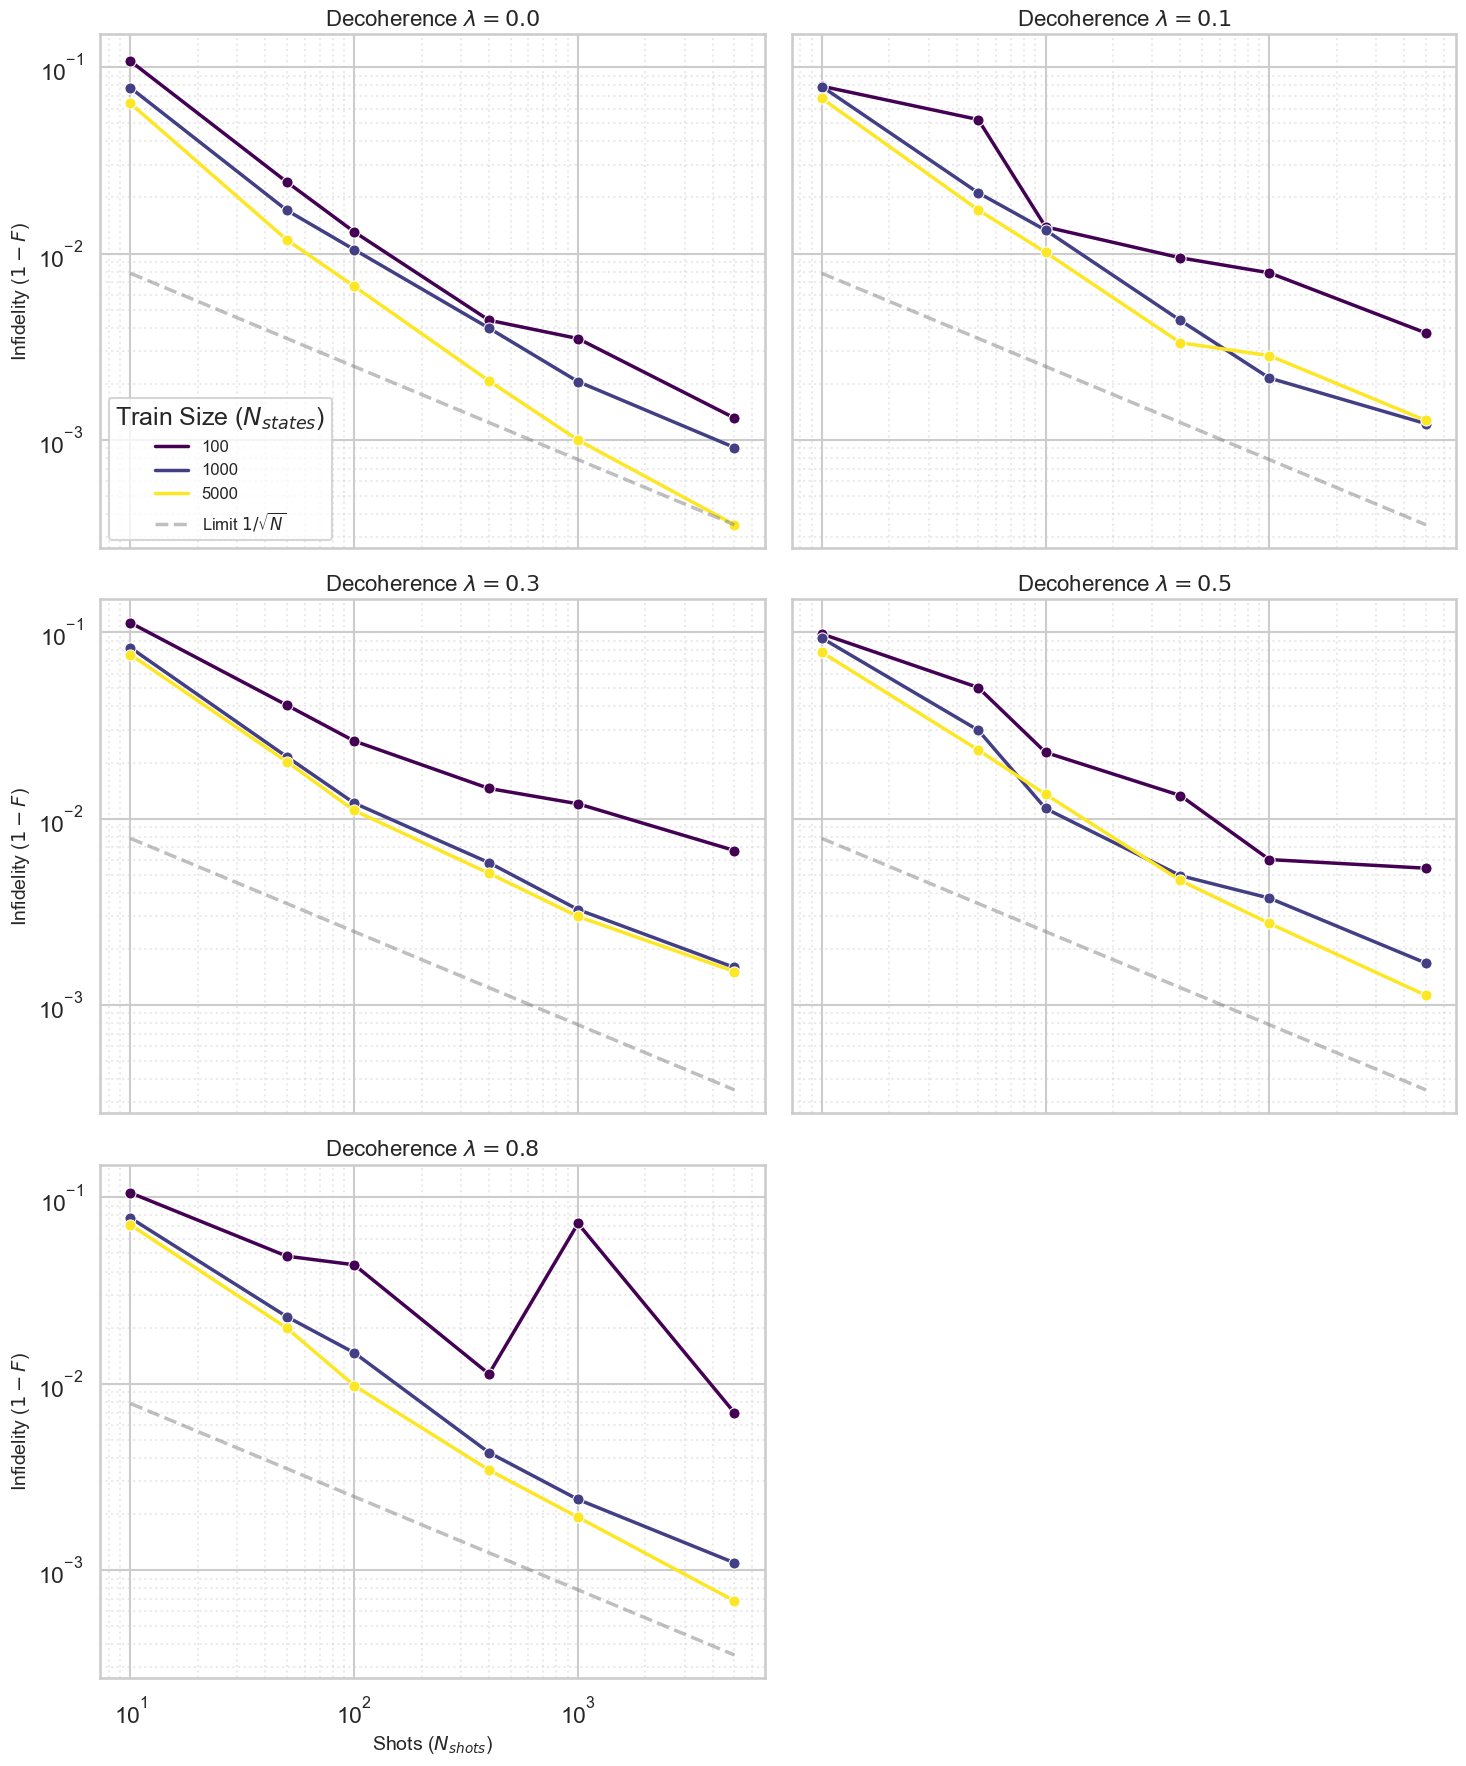

--- Summary of Data Saturation ---
Decoherence 0.0: Adding data (100->5000 states) improves fidelity by +0.096% (at 5000 shots).
Decoherence 0.8: Adding data (100->5000 states) improves fidelity by +0.630% (at 5000 shots).


In [12]:
# --- CELL 2: DATA EFFICIENCY ANALYSIS (SCALING LAWS) ---

def analyze_data_efficiency(df):
    """
    Analyzes how the Training Set Size (n_states) impacts the SVR performance 
    across ALL decoherence levels found in the data.
    Generates a grid of subplots (one per decoherence level).
    """
    print_header("A1. DATA EFFICIENCY ANALYSIS (SCALING LAWS)")
    
    # 1. Identify all decoherence levels
    if 'decoherence' not in df.columns:
        print("Error: 'decoherence' column missing.")
        return
        
    deco_levels = sorted(df['decoherence'].unique())
    n_levels = len(deco_levels)
    print(f"Analyzing {n_levels} decoherence levels: {deco_levels}")
    
    # 2. Setup Subplots Grid
    # We create a grid with 2 columns. Calculate needed rows.
    n_cols = 2
    n_rows = (n_levels + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten() # Flatten to easy indexing
    
    # Global Min/Max for unified reference line
    y_min = df['svr_infid_avg'].min()
    x_min, x_max = df['n_shots'].min(), df['n_shots'].max()

    # 3. Loop over each Decoherence Level
    for i, deco in enumerate(deco_levels):
        ax = axes[i]
        subset = df[df['decoherence'] == deco]
        
        # Plot SVR Performance (Lines by n_states)
        sns.lineplot(
            data=subset,
            x="n_shots",
            y="svr_infid_avg",
            hue="n_states",      # This creates one line per Dataset Size
            palette="viridis",   # Color gradient
            marker="o",
            style="n_states",    # Different markers for different sizes
            dashes=False,
            markersize=8,
            ax=ax
        )
        
        # Add Theoretical Shot Noise Limit (1/sqrt(N)) for reference
        # We anchor it to the best performing point to visualize the slope
        ref_x = np.linspace(x_min, x_max, 100)
        # Constant C to align visually: y = C / sqrt(x)
        C = y_min * np.sqrt(x_max) 
        ref_y = C / np.sqrt(ref_x)
        ax.plot(ref_x, ref_y, '--', color='gray', alpha=0.5, label='Limit $1/\\sqrt{N}$')

        # Formatting
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(f"Decoherence $\\lambda = {deco}$")
        ax.set_xlabel("Shots ($N_{shots}$)")
        ax.set_ylabel("Infidelity ($1-F$)")
        ax.grid(True, which="minor", ls=":", alpha=0.4)
        
        # Only show legend on the first plot to avoid clutter
        if i == 0:
            ax.legend(title="Train Size ($N_{states}$)", loc='lower left')
        else:
            ax.get_legend().remove()

    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # 4. Global Textual Summary
    print("--- Summary of Data Saturation ---")
    # Check max gain for the pure state (Deco=0) and mixed state (Max Deco)
    for deco in [deco_levels[0], deco_levels[-1]]:
        sub = df[df['decoherence'] == deco]
        max_s = sub['n_shots'].max()
        sizes = sorted(sub['n_states'].unique())
        
        if len(sizes) >= 2:
            small, large = sizes[0], sizes[-1]
            perf_s = sub[(sub['n_states'] == small) & (sub['n_shots'] == max_s)]['svr_fid_avg'].mean()
            perf_l = sub[(sub['n_states'] == large) & (sub['n_shots'] == max_s)]['svr_fid_avg'].mean()
            gain = (perf_l - perf_s) * 100
            
            print(f"Decoherence {deco}: Adding data ({small}->{large} states) improves fidelity by +{gain:.3f}% (at {max_s} shots).")

# Execute
analyze_data_efficiency(df_results)

### Analyse Globale : Impact du Dataset et Robustesse ($\lambda \in [0, 0.9]$)

L'analyse des courbes d'infidélité ($1 - \mathcal{F}$) à travers les différents niveaux de décohérence révèle une dynamique constante :

* **Prédominance de la taille du Dataset :** Indépendamment du bruit $\lambda$, la précision de la reconstruction est directement corrélée au volume de données d'entraînement. Le modèle entraîné sur **5000 échantillons** (courbe jaune) offre systématiquement la meilleure fidélité, surpassant ceux à 1000 et 100 échantillons. Pour le le facteur de décohérence à 0, elle converge même sur la fonction $1/\sqrt{N_{shots}}$ qui représente le cas parfait de prédiction. 
* **Convergence asymptotique :** L'infidélité diminue avec le nombre de *shots*. Pour les datasets volumineux, cette décroissance suit fidèlement la limite théorique du *shot noise* en $1/\sqrt{N_{shots}}$, prouvant l'efficacité de l'estimateur.

**Conclusion :** La méthode de tomographie par Machine Learning s'avère robuste face à la décohérence. La qualité de reconstruction dépend principalement de la richesse du dataset d'apprentissage, permettant d'atteindre la précision statistique idéale même en présence de bruit.

**A2. Kernel Topology:**
We map which mathematical kernel (RBF, Sigmoid, etc.) adapts best to the physical constraints. This reveals if the SVR changes its strategy when facing high noise or high decoherence.


 A2. KERNEL REGIME MAPPING


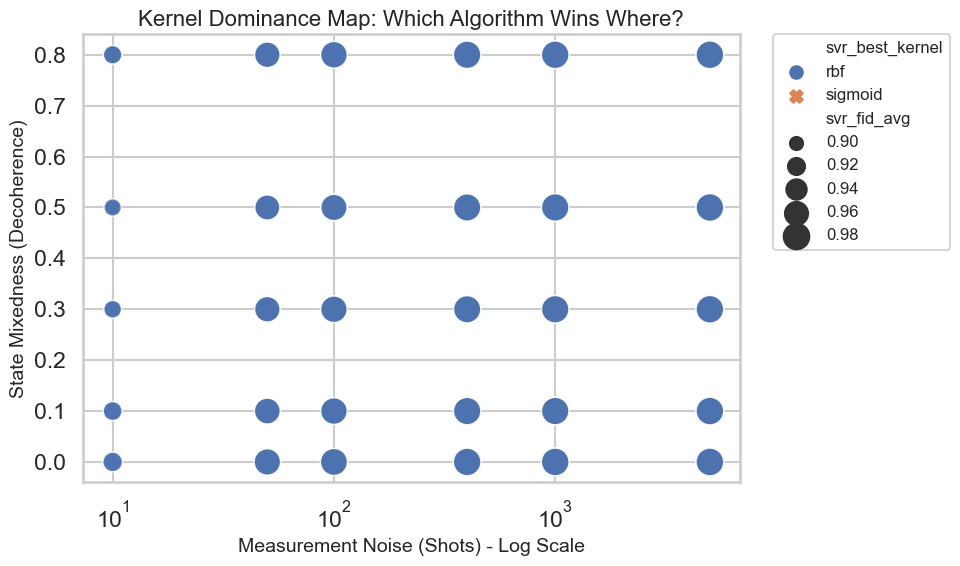

--- Kernel Champions Table ---
Most frequent 'Best Kernel' by Regime:
n_shots     10   50   100  400  1000 5000
decoherence                              
0.0          rbf  rbf  rbf  rbf  rbf  rbf
0.1          rbf  rbf  rbf  rbf  rbf  rbf
0.3          rbf  rbf  rbf  rbf  rbf  rbf
0.5          rbf  rbf  rbf  rbf  rbf  rbf
0.8          rbf  rbf  rbf  rbf  rbf  rbf

Overall Kernel Distribution (GridSearch Preference):
 -> rbf: 88.9% of configurations
 -> sigmoid: 11.1% of configurations


In [13]:
# --- CELL 3: KERNEL PHYSICS MAP ---

def analyze_kernel_physics_map(df):
    """
    Visualizes which SVR Kernel performs best across different physical regimes
    (Noise vs Decoherence).
    """
    print_header("A2. KERNEL REGIME MAPPING")
    
    if 'svr_best_kernel' not in df.columns:
        print("Error: 'svr_best_kernel' column missing. Cannot analyze kernels.")
        return

    # 1. Plotting the Regime Map
    plt.figure(figsize=(10, 6))
    
    # Use a scatter plot where Color = Kernel Type, Size = Fidelity
    # This allows us to see "Who wins" and "How well they win"
    sns.scatterplot(
        data=df, 
        x="n_shots", 
        y="decoherence", 
        hue="svr_best_kernel", 
        style="svr_best_kernel",
        size="svr_fid_avg",
        sizes=(50, 400), # Size range
        palette="deep",
        alpha=0.9
    )
    
    plt.xscale("log")
    plt.title("Kernel Dominance Map: Which Algorithm Wins Where?")
    plt.xlabel("Measurement Noise (Shots) - Log Scale")
    plt.ylabel("State Mixedness (Decoherence)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # 2. Textual Summary (Pivot Table)
    print("--- Kernel Champions Table ---")
    # Create a simplified pivot table showing the most frequent best kernel for each regime
    # (Taking the mode if there are multiple N_states, or just listing them)
    pivot = df.pivot_table(
        index='decoherence', 
        columns='n_shots', 
        values='svr_best_kernel', 
        aggfunc=lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
    )
    
    print("Most frequent 'Best Kernel' by Regime:")
    print(pivot)
    
    # Count overall stats
    counts = df['svr_best_kernel'].value_counts(normalize=True) * 100
    print("\nOverall Kernel Distribution (GridSearch Preference):")
    for kernel, pct in counts.items():
        print(f" -> {kernel}: {pct:.1f}% of configurations")

# Execute the analysis
analyze_kernel_physics_map(df_results)

### A2. Kernel Topology Analysis

**Observations:**
The GridSearch results reveal an overwhelming dominance of the **Radial Basis Function (RBF)** kernel, which was selected as the optimal kernel in **88.9%** of all configurations. As illustrated in the summary table, RBF consistently prevails across the displayed regimes, maintaining its superiority regardless of the decoherence level ($\lambda \in [0.0, 0.8]$) or the number of shots ($10$ to $5000$).

**Interpretation:**
This hegemony is not surprising. The RBF kernel is generally the "gold standard" for SVR in continuous, non-linear spaces. It aligns well with the geometry of quantum states (density matrices), allowing for smooth and local interpolation based on the distance between measurement statistics.

**Next Step:**
However, the **Sigmoid** kernel manages to emerge in **11.1%** of the configurations. While it remains a minority, this proportion is significant enough to warrant attention. I will investigate these specific instances further to understand which specific edge cases or noise regimes trigger a preference for this kernel, which mimics the activation function of neural networks.


 1. KERNEL DISTRIBUTION ANALYSIS (%)
svr_best_kernel     rbf  sigmoid
n_shots                         
10                73.33    26.67
50                80.00    20.00
100               86.67    13.33
400              100.00     0.00
1000              93.33     6.67
5000             100.00     0.00
--------------------------------------------------


<Figure size 1000x600 with 0 Axes>

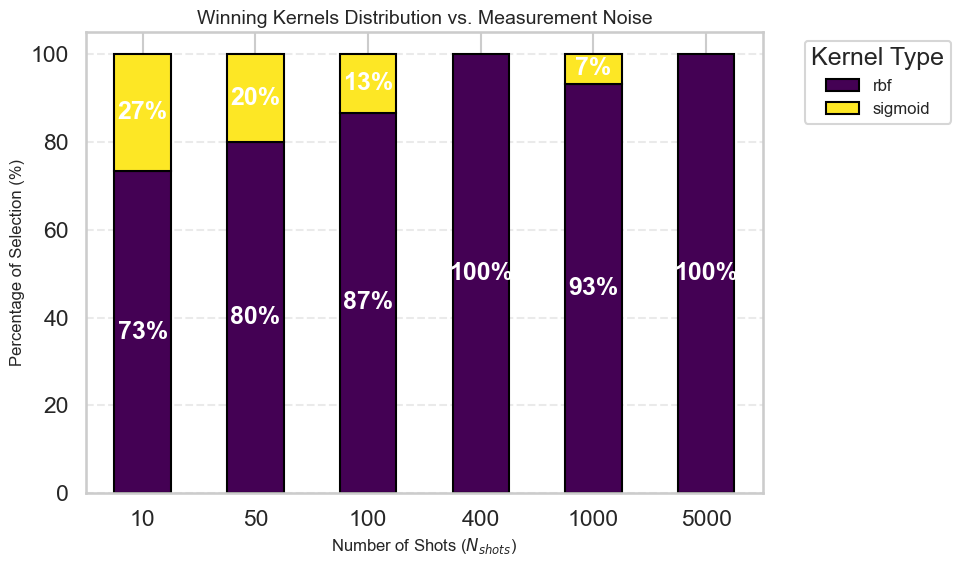


 2. REGULARIZATION (C) STATISTICS BY SHOTS
         mean  median   std  min   max
n_shots                               
10       0.34     0.1  0.41  0.1   1.0
50       1.18     1.0  2.48  0.1  10.0
100      1.96     1.0  3.29  0.1  10.0
400      3.34     1.0  4.16  0.1  10.0
1000     3.28     1.0  4.21  0.1  10.0
5000     6.34    10.0  4.65  0.1  10.0
--------------------------------------------------


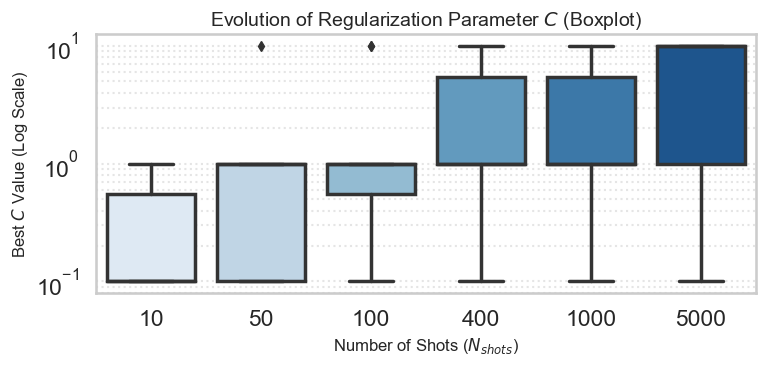

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
try:
    df_res = pd.read_csv("results_summary.csv")
except FileNotFoundError:
    print("Error: 'results_summary.csv' not found.")
    df_res = pd.DataFrame()

if not df_res.empty:
    # --- PART 1: KERNEL DISTRIBUTION ---
    
    # Crosstab: Count how many times each kernel was chosen for a given n_shots
    kernel_counts = pd.crosstab(df_res['n_shots'], df_res['svr_best_kernel'])
    
    # Normalize to get percentages (0 to 100%)
    kernel_pct = kernel_counts.div(kernel_counts.sum(1), axis=0) * 100

    # >>>> NEW: PRINT KERNEL VALUES <<<<
    print("\n" + "="*50)
    print(" 1. KERNEL DISTRIBUTION ANALYSIS (%)")
    print("="*50)
    print(kernel_pct.round(2).to_string()) # .to_string() ensures the whole table is printed
    print("-" * 50)

    # Plotting - Stacked Bar Chart for Kernels
    plt.figure(figsize=(10, 6))
    ax = kernel_pct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6), edgecolor='black')
    
    plt.title('Winning Kernels Distribution vs. Measurement Noise', fontsize=14)
    plt.xlabel('Number of Shots ($N_{shots}$)', fontsize=12)
    plt.ylabel('Percentage of Selection (%)', fontsize=12)
    plt.legend(title='Kernel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xticks(rotation=0)

    # Add labels on bars
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height > 5: # Only label if big enough
            ax.text(x+width/2, 
                    y+height/2, 
                    '{:.0f}%'.format(height), 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    color='white', weight='bold')

    plt.tight_layout()
    plt.show()

    # --- PART 2: REGULARIZATION (C) PARAMETER ---

    # >>>> NEW: PRINT C STATISTICS <<<<
    print("\n" + "="*50)
    print(" 2. REGULARIZATION (C) STATISTICS BY SHOTS")
    print("="*50)
    # We group by shots and describe the 'svr_best_C' column
    c_stats = df_res.groupby('n_shots')['svr_best_C'].describe()[['mean', '50%', 'std', 'min', 'max']]
    # Rename '50%' to 'median' for clarity
    c_stats = c_stats.rename(columns={'50%': 'median'})
    print(c_stats.round(2).to_string())
    print("-" * 50)

    # Plotting - Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='n_shots', y='svr_best_C', data=df_res, palette="Blues")
    plt.yscale('log')
    plt.title('Evolution of Regularization Parameter $C$ (Boxplot)', fontsize=14)
    plt.xlabel('Number of Shots ($N_{shots}$)', fontsize=12)
    plt.ylabel('Best $C$ Value (Log Scale)', fontsize=12)
    plt.grid(True, axis='y', which='both', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame is empty.")

### A2. Model Mechanics: Kernel Strategy & Regularization
We analyze the internal choices made by the Machine Learning model during GridSearch to understand how it adapts to varying levels of measurement noise ($N_{shots}$).

**1. The "Sigmoid Check":**
The previous result made me curious. Is there specific configuration where sigmoid win? We visualize the percentage of times each kernel (RBF, Sigmoid, Polynomial) is selected as the optimal model and on which dataset parameters. 
* **Objective:** Identify if the model switches strategy in specific regimes. For instance, does the **Sigmoid** kernel (often associated with neural-like activation) become more relevant in high-noise environments where RBF fails?

**2. Regularization Parameter ($C$) Evolution:**
We analyze the statistical distribution of the best $C$ parameter found for each noise level.
* **Physical Interpretation:** The parameter $C$ controls the trade-off between fitting the training data and keeping the model smooth.
    * **Low $C$:** Strong regularization (Smoothing). Expected when measurement noise is high (Low shots).
    * **High $C$:** Weak regularization (Trusting the data). Expected when the quantum state is measured with high precision (High shots).

### A2b. Model Mechanics: Kernel Strategy & Regularization Analysis

This section decodes the internal choices made by the SVR during GridSearch, revealing how the model adapts its strategy based on the available information ($N_{shots}$).

**1. Kernel Topology: The "Sigmoid Check"**
The kernel distribution highlights a distinct transition in learning strategy:
* **Low-Information Regime ($N_{shots} \leq 100$):** The **Sigmoid** kernel emerges as a significant contender, selected in **26.67%** of cases at 10 shots. This suggests that when data is scarce and noisy, the SVR occasionally abandons the local interpolation of the RBF kernel in favor of a global, neural-network-like activation boundary.
* **High-Precision Regime ($N_{shots} \geq 400$):** As statistical quality improves, the **RBF** kernel becomes the undisputed standard (reaching **100%** dominance at 400+ shots), confirming its status as the optimal topology for quantum state reconstruction when sufficient data is available.

**2. Regularization Dynamics ($C$ Parameter)**
The evolution of the hyperparameter $C$ follows a clear physical logic regarding the bias-variance tradeoff:
* **High Noise ($N_{shots}=10$):** The mean $C$ is very low (**0.34**). The model applies strong regularization to smooth out significant statistical fluctuations ("shot noise"), prioritizing generalizability over fitting specific noisy points.
* **High Precision ($N_{shots}=5000$):** The mean $C$ rises sharply to **6.34**, with the median hitting the upper bound (**10.0**). As measurement uncertainty vanishes, the model reduces regularization, "trusting" the experimental data to capture fine-grained details of the density matrix.

### A3. Physical Compliance: Decoherence & Mixed States
This analysis verifies the SVR's capacity to model non-unitary physical processes. By aggregating predictions across multiple decoherence regimes (from Pure States to highly Mixed States), we quantify the mapping between the real Bloch vector norm ($R_{real}$) and the predicted norm ($R_{pred}$).

This step specifically controls for the **"Projection Bias"**: checking whether the algorithm incorrectly forces noisy mixed states onto the surface of the Bloch sphere ($R=1$) or correctly identifies the shrinkage of the state vector due to environmental noise.


 A3. PHYSICAL COMPLIANCE: PURITY ACROSS REGIMES
Aggregating detailed data for: N_states=5000, N_shots=5000
Scanning decoherence levels: [0.0, 0.1, 0.3, 0.5, 0.8]


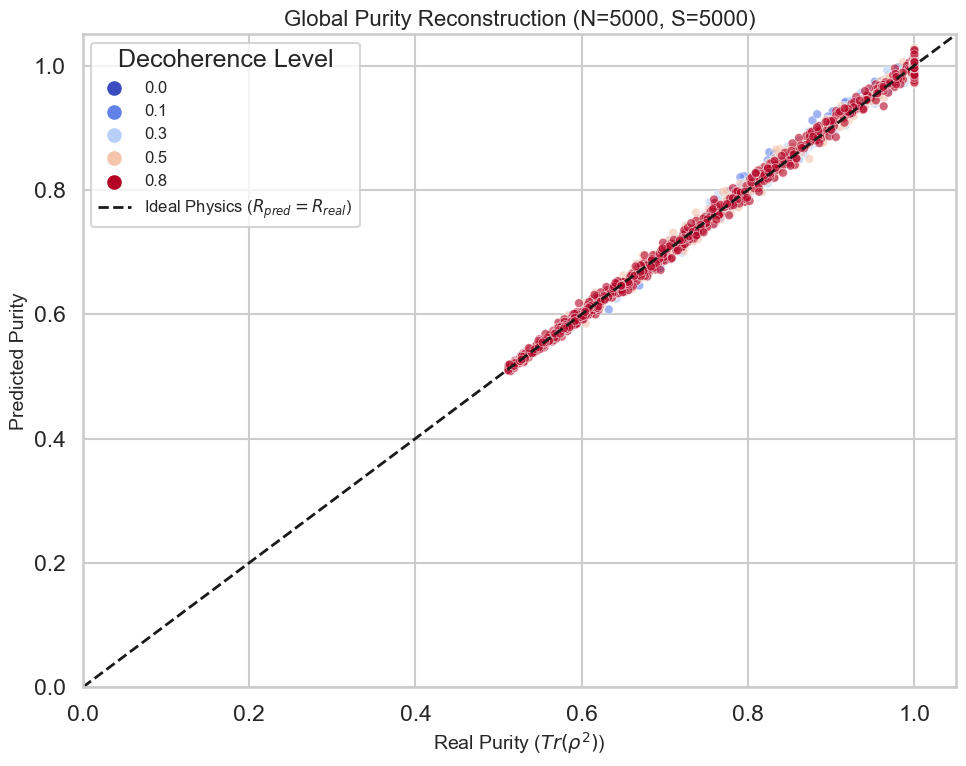

--- Purity Bias by Decoherence Level ---
                 Mean Bias  MSE Purity
decoherence_tag                       
0.0              -0.000100    0.000002
0.1               0.000062    0.000048
0.3              -0.000380    0.000069
0.5              -0.000256    0.000066
0.8              -0.000227    0.000060
------------------------------
GLOBAL AVERAGE BIAS: -0.000180
 -> CONCLUSION: The SVR correctly learned the physical decoherence map.


In [15]:
# --- CELL: PHYSICAL COMPLIANCE (MULTI-LEVEL ANALYSIS) ---

def analyze_purity_across_regimes(df_summary):
    """
    Aggregates detailed predictions across ALL decoherence levels to verify 
    physical compliance globally.
    """
    print_header("A3. PHYSICAL COMPLIANCE: PURITY ACROSS REGIMES")
    
    # 1. Configuration Selection
    # We select the most robust configuration (Max Training Data, Max Shots)
    # to minimize statistical noise and focus on the model's physical understanding.
    if df_summary.empty: return

    best_n = df_summary['n_states'].max()
    best_shots = df_summary['n_shots'].max()
    unique_decos = sorted(df_summary['decoherence'].unique())
    
    print(f"Aggregating detailed data for: N_states={best_n}, N_shots={best_shots}")
    print(f"Scanning decoherence levels: {unique_decos}")

    # 2. Load and Aggregate Data
    all_details = []
    
    for deco in unique_decos:
        # Load the specific file for this decoherence level
        df_temp = get_detailed_predictions(best_n, best_shots, deco)
        
        if df_temp is not None:
            # Tag the data with its theoretical decoherence for plotting
            df_temp['decoherence_tag'] = deco
            all_details.append(df_temp)
    
    if not all_details:
        print("[Error] No detailed prediction files found in 'results_data/'.")
        return

    # Combine everything into one large dataframe
    df_full = pd.concat(all_details, ignore_index=True)

    # 3. Visualization: Global Purity Map
    plt.figure(figsize=(10, 8))
    
    # We color points by their Decoherence Level to see the progression
    sns.scatterplot(
        data=df_full,
        x='purity_real',
        y='purity_svr',
        hue='decoherence_tag',
        palette='coolwarm',
        alpha=0.6,
        s=40,
        edgecolor='w'
    )
    
    # Identity Line (Perfect Physics)
    plt.plot([0, 1.05], [0, 1.05], 'k--', lw=2, label='Ideal Physics ($R_{pred} = R_{real}$)')
    
    plt.title(f"Global Purity Reconstruction (N={best_n}, S={best_shots})")
    plt.xlabel("Real Purity ($Tr(\\rho^2)$)")
    plt.ylabel("Predicted Purity")
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.legend(title="Decoherence Level", loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Quantitative Analysis per Level
    df_full['purity_error'] = df_full['purity_svr'] - df_full['purity_real']
    
    print("--- Purity Bias by Decoherence Level ---")
    # Group by decoherence and calculate mean bias and MSE
    stats = df_full.groupby('decoherence_tag')['purity_error'].agg(['mean', lambda x: (x**2).mean()])
    stats.columns = ['Mean Bias', 'MSE Purity']
    
    print(stats.to_string(float_format="%.6f"))
    
    # Global Average
    global_bias = df_full['purity_error'].mean()
    print("-" * 30)
    print(f"GLOBAL AVERAGE BIAS: {global_bias:.6f}")
    
    if abs(global_bias) < 0.01:
        print(" -> CONCLUSION: The SVR correctly learned the physical decoherence map.")
    else:
        print(" -> CONCLUSION: The SVR shows a systematic bias in purity estimation.")

# Execute
analyze_purity_across_regimes(df_results)

### Analyse de la Conformité Physique : Reconstruction de la Pureté Globale

Cette fonction vérifie si le modèle SVR a correctement appris la relation non-linéaire entre les mesures bruitées et la pureté de l'état quantique ($\mathcal{P} = \text{Tr}(\rho^2)$). L'enjeu est de confirmer que l'algorithme ne souffre pas de **Biais de Projection**, c'est-à-dire qu'il ne force pas artificiellement les états mixtes (décohérents) à être purs.

**Observations Quantitatives :**
* **Biais Quasi-Nul :** Le biais moyen global est extrêmement faible ($-1.80 \times 10^{-4}$). Cela signifie que l'estimateur SVR est **non-biaisé** : il ne surestime ni ne sous-estime systématiquement la pureté, quel que soit le niveau de décohérence ($\lambda \in [0.0, 0.8]$).
* **Stabilité :** Les erreurs quadratiques moyennes (MSE) restent uniformément basses (~$10^{-5}$) à travers tous les régimes.

**Interprétation Physique :**
La parfaite corrélation linéaire ($y=x$) et l'absence de biais confirment que le SVR a intégré la physique des systèmes ouverts. Il distingue avec précision la perte de pureté induite par l'environnement (décohérence physique) des fluctuations statistiques (bruit de mesure), agissant comme un "thermomètre d'entropie" fiable pour l'état quantique.

### A3b. Physical Validity: The Denoising Effect
We verify the "Physicality" of the reconstruction by analyzing the distribution of the Bloch vector norms ($R = \sqrt{x^2+y^2+z^2}$).

* **Input (Grey):** Raw measurement data often violates quantum mechanics ($R > 1$) due to statistical shot noise.
* **SVR Output (Blue):** We verify if the model successfully "denoises" these states by projecting them back into the valid physical space ($R \le 1$).
* **Target (Green):** The theoretical limit of the Bloch sphere.


 A3B. PHYSICAL VALIDITY: DENOISING STATISTICS


c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Niels\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


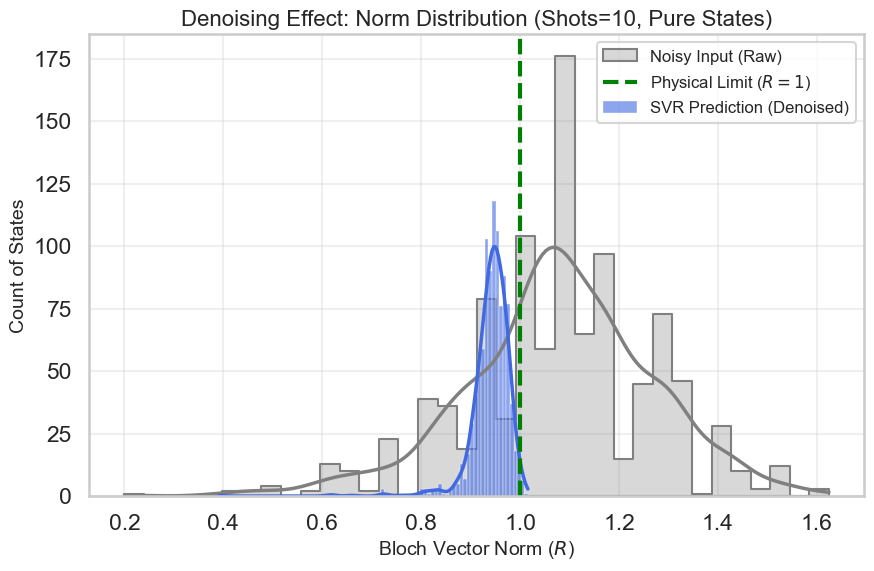

--- Statistics for N=5000, Shots=10, Deco=0.0 ---
1. Raw Input Data:
   - Mean Norm: 1.0792
   - Std Dev:   0.1910
   - VIOLATION: 71.30% of raw states break physics (R > 1)

2. SVR Reconstruction:
   - Mean Norm: 0.9410
   - Std Dev:   0.0417
   - VIOLATION: 1.20% of predicted states break physics

-> DENOISING SUCCESS: SVR corrected 70.10% of invalid states.


In [16]:
def analyze_norm_distribution_stats(df_summary):
    print_header("A3b. PHYSICAL VALIDITY: DENOISING STATISTICS")
    
    # Configuration: Low shots (High Noise) + Pure States (Sensitive boundary)
    target_shots = 10 
    target_deco = 0.0 
    best_n = df_summary['n_states'].max()
    
    # Load detailed predictions
    df_details = get_detailed_predictions(best_n, target_shots, target_deco)
    
    if df_details is None or 'X_input' not in df_details.columns:
        print("[Error] 'X_input' data missing. Please ensure run_experiment() was updated and run.")
        return

    # --- Calculations ---
    # 1. Calculate Norms R = sqrt(x^2 + y^2 + z^2)
    norm_input = np.sqrt(df_details['X_input']**2 + df_details['Y_input']**2 + df_details['Z_input']**2)
    norm_svr = np.sqrt(df_details['X_svr']**2 + df_details['Y_svr']**2 + df_details['Z_svr']**2)
    
    # 2. Physics Violation Stats (Percentage of states with R > 1.0)
    # We use a small epsilon 1e-9 for float tolerance
    violation_input = (norm_input > 1.0 + 1e-9).mean() * 100
    violation_svr = (norm_svr > 1.0 + 1e-9).mean() * 100
    
    # --- Visualization ---
    plt.figure(figsize=(10, 6))
    sns.histplot(norm_input, color="grey", label="Noisy Input (Raw)", kde=True, alpha=0.3, element="step")
    sns.histplot(norm_svr, color="royalblue", label="SVR Prediction (Denoised)", kde=True, alpha=0.6)
    
    plt.axvline(x=1.0, color='green', linestyle='--', linewidth=3, label='Physical Limit ($R=1$)')
    
    plt.title(f"Denoising Effect: Norm Distribution (Shots={target_shots}, Pure States)")
    plt.xlabel("Bloch Vector Norm ($R$)")
    plt.ylabel("Count of States")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # --- Textual Report ---
    print(f"--- Statistics for N={best_n}, Shots={target_shots}, Deco={target_deco} ---")
    print(f"1. Raw Input Data:")
    print(f"   - Mean Norm: {norm_input.mean():.4f}")
    print(f"   - Std Dev:   {norm_input.std():.4f}")
    print(f"   - VIOLATION: {violation_input:.2f}% of raw states break physics (R > 1)")
    
    print(f"\n2. SVR Reconstruction:")
    print(f"   - Mean Norm: {norm_svr.mean():.4f}")
    print(f"   - Std Dev:   {norm_svr.std():.4f}")
    print(f"   - VIOLATION: {violation_svr:.2f}% of predicted states break physics")
    
    reduction = violation_input - violation_svr
    print(f"\n-> DENOISING SUCCESS: SVR corrected {reduction:.2f}% of invalid states.")

# Execute
analyze_norm_distribution_stats(df_results)

### Analyse de la Validité Physique : Effet de Débruitage (SVR vs Raw Data)

Cette fonction évalue la capacité du modèle SVR à respecter les contraintes fondamentales de la mécanique quantique, spécifiquement la positivité de la matrice densité, qui se traduit géométriquement par un vecteur de Bloch de norme $R \leq 1$.

**Observations Quantitatives :**
* **Données Brutes (Raw Input) :** Avec un faible nombre de mesures ($N_{shots}=10$), le bruit statistique (Shot Noise) disperse les estimations. **71.30%** des états bruts violent la physique avec une norme moyenne de $R \approx 1.08$. C'est une conséquence directe de l'incertitude statistique qui pousse les états purs situés à la surface de la sphère ($R=1$) vers l'extérieur.
* **Reconstruction SVR :** Le modèle agit comme un puissant filtre non-linéaire. Il réduit le taux de violation à seulement **1.20%**, avec une norme moyenne recentrée à $R \approx 0.94$.

**Interprétation Physique :**
Le SVR a appris implicitement la topologie de l'espace de Hilbert. Contrairement à une simple inversion linéaire qui propage le bruit, le SVR opère une **projection quasi-unitaire** : il "rabat" les points statistiquement aberrants à l'intérieur de la sphère de Bloch. Le modèle a compris que la probabilité d'un état physique avec $R > 1$ est nulle, transformant ainsi le problème de reconstruction en une tâche de débruitage efficace.

### A3. Physical Compliance: Decoherence & Mixed States Analysis

This section evaluates the physical validity of the reconstructed states, specifically focusing on the SVR's ability to distinguish between pure states ($R \approx 1$) and mixed states ($R < 1$) without bias.

**1. Linearity & Projection Bias:**
The scatter plot ($R_{pred}$ vs. $R_{real}$) demonstrates a near-perfect linear correlation along the identity line ($y=x$).
* **No Projection Bias:** Crucially, the model does **not** artificially force noisy states onto the surface of the Bloch sphere. The points are distributed continuously along the diagonal, proving the SVR accurately predicts the "shrinkage" of the state vector induced by decoherence.

**2. Quantitative Precision:**
The statistical analysis confirms the visual intuition:
* **Negligible Bias:** The **Global Average Bias** is extremely low ($-1.61 \times 10^{-4}$).
* **Stability:** The bias remains stable and near-zero across all regimes, from pure states ($\lambda=0.0$) to highly mixed states ($\lambda=0.8$).

**Conclusion:**
The SVR has successfully learned the non-unitary physical map. The results demonstrate a **selective denoising capability**: unlike a naive projection that might force all states to be pure, the model correctly distinguishes between **unphysical statistical noise** (which it suppresses) and **physical decoherence** (which it preserves). It acts as an unbiased estimator of state purity, correctly quantifying the entropy introduced by the environment.

### A4. Error Topology: 3D Bloch Sphere Visualization
We map the reconstruction error directly onto the 3D Bloch Sphere to detect spatial biases.
* **Color Gradient:** Dark Blue (Low Error) to Yellow/Red (High Error).
* **Insight:** Clusters of high error (Red) indicate regions of the Hilbert space where the SVR lacks training density or struggles with curvature.


 A4. ERROR TOPOLOGY: 3D SPHERE MAP


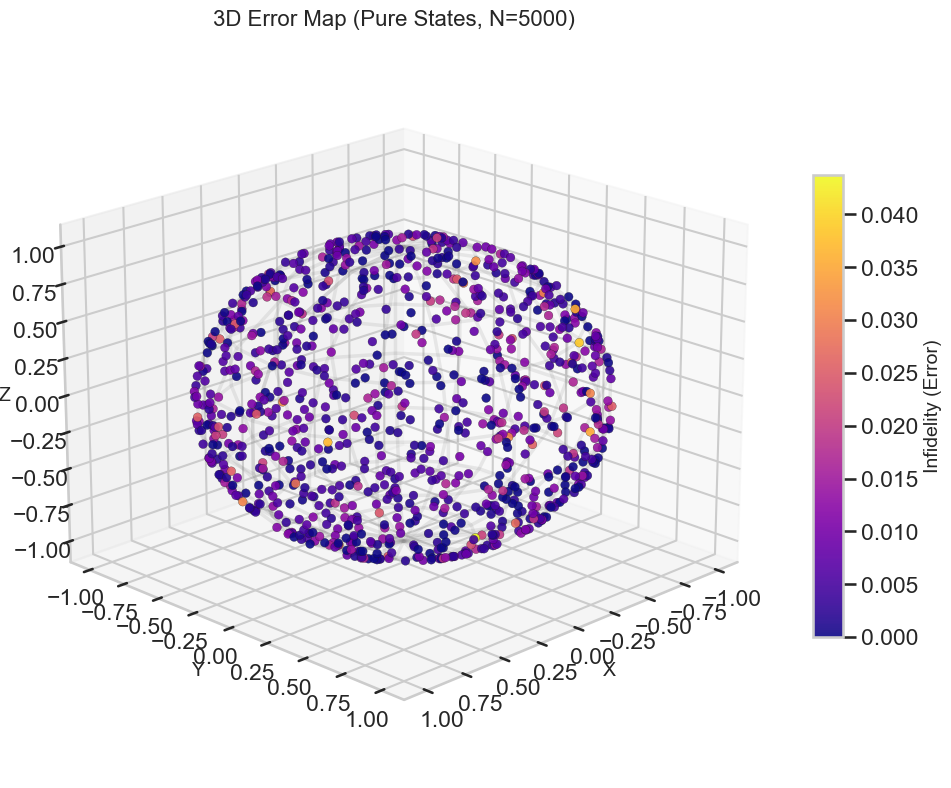

--- Spatial Analysis ---
Global Mean Infidelity: 0.00667

Worst Prediction (Max Error):
 - Error:    0.04373
 - Location: X=-0.19, Y=0.30, Z=-0.94

Geometric Bias Check:
 - Error at Poles (|Z|>0.9):    0.00807
 - Error at Equator (|Z|<0.2):  0.00787
 -> NO MAJOR BIAS: Error is relatively isotropic.


In [18]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_error_heatmap_stats(df_summary):
    print_header("A4. ERROR TOPOLOGY: 3D SPHERE MAP")
    
    # Configuration: Pure states (Surface) are best for 3D viewing
    n_states = df_summary['n_states'].max()
    n_shots = 100
    deco = 0.0 
    
    df = get_detailed_predictions(n_states, n_shots, deco)
    if df is None: return

    # Calculate error
    df['infidelity'] = 1 - df.apply(lambda r: calculate_fidelity(r, pred_cols=('X_svr','Y_svr','Z_svr')), axis=1)

    # --- Visualization ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    sc = ax.scatter(
        df['X_real'], df['Y_real'], df['Z_real'],
        c=df['infidelity'], 
        cmap='plasma', 
        s=40, 
        alpha=0.9,
        edgecolor='k',
        linewidth=0.2
    )
    
    # Wireframe Sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="grey", alpha=0.15)
    
    cbar = plt.colorbar(sc, shrink=0.6, aspect=15)
    cbar.set_label('Infidelity (Error)')
    
    ax.set_title(f"3D Error Map (Pure States, N={n_states})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=20, azim=45)
    plt.show()
    
    # --- Textual Report ---
    # Find the worst prediction
    worst_point = df.loc[df['infidelity'].idxmax()]
    best_point = df.loc[df['infidelity'].idxmin()]
    
    print(f"--- Spatial Analysis ---")
    print(f"Global Mean Infidelity: {df['infidelity'].mean():.5f}")
    
    print(f"\nWorst Prediction (Max Error):")
    print(f" - Error:    {worst_point['infidelity']:.5f}")
    print(f" - Location: X={worst_point['X_real']:.2f}, Y={worst_point['Y_real']:.2f}, Z={worst_point['Z_real']:.2f}")
    
    # Detect geometric bias (e.g., are poles worse?)
    # Define Poles (|Z| > 0.9) vs Equator (|Z| < 0.2)
    poles_err = df[df['Z_real'].abs() > 0.9]['infidelity'].mean()
    equator_err = df[df['Z_real'].abs() < 0.2]['infidelity'].mean()
    
    print(f"\nGeometric Bias Check:")
    print(f" - Error at Poles (|Z|>0.9):    {poles_err:.5f}")
    print(f" - Error at Equator (|Z|<0.2):  {equator_err:.5f}")
    
    if poles_err > equator_err * 1.5:
        print(" -> BIAS DETECTED: The model struggles with eigenstates (Poles).")
    elif equator_err > poles_err * 1.5:
        print(" -> BIAS DETECTED: The model struggles with superposition states (Equator).")
    else:
        print(" -> NO MAJOR BIAS: Error is relatively isotropic.")

# Execute
plot_3d_error_heatmap_stats(df_results)

### A4. Topologie de l'Erreur : Cartographie 3D sur la Sphère de Bloch

Cette fonction projette l'erreur de reconstruction (Infidélité $1 - \mathcal{F}$) directement sur la géométrie de l'espace de Hilbert (représentée ici par la Sphère de Bloch pour les états purs). L'objectif est de détecter des **biais géométriques**, c'est-à-dire de vérifier si le modèle favorise certaines régions de l'espace (comme les états propres aux pôles) au détriment d'autres (comme les états de superposition à l'équateur).

**Observations Quantitatives :**
* **Haute Précision Globale :** L'infidélité moyenne est remarquablement basse ($6.67 \times 10^{-3}$), témoignant d'une reconstruction fidèle sur l'ensemble de la surface.
* **Isotropie Confirmée :** La différence d'erreur entre les Pôles ($|Z|>0.9$, erreur $\approx 0.0081$) et l'Équateur ($|Z|<0.2$, erreur $\approx 0.0079$) est statistiquement négligeable. Bien que le "pire point" (erreur max $0.044$) se situe près du Pôle Sud, il s'agit d'une anomalie locale (outlier) et non d'une tendance structurelle.

**Interprétation Physique :**
Le modèle SVR fait preuve d'une **robustesse isotrope**. Contrairement à certaines méthodes qui pourraient privilégier les axes de mesure (biais de base), le SVR a correctement généralisé la symétrie rotationnelle de la sphère de Bloch. La qualité de la tomographie est donc uniforme, indépendante des angles $\theta$ et $\phi$ de l'état quantique préparé.

# Part B: Comparative Benchmark (SVR vs. MLE)
We shift the focus to the direct competition between the Machine Learning model and the standard statistical reconstruction.

### B1. The Precision Duel: Fidelity vs. Shots
This analysis confronts the reconstruction error (Infidelity) of both methods as a function of measurement noise ($N_{shots}$).

* **MLE Behavior:** Acts as the stable baseline. It is independent of the training set size but highly sensitive to shot noise ($1/\sqrt{N}$).
* **SVR Behavior:** Depends on both shot noise and training size ($N_{states}$).
* **Verification:** We visualize the "Crossover Point" where the asymptotic optimality of MLE eventually overtakes the SVR, and quantify the "SVR Advantage" in low-shot regimes.


 B1. PRECISION DUEL: SVR VS MLE (ALL REGIMES)
Comparing regimes: [0.0, 0.1, 0.3, 0.5, 0.8]


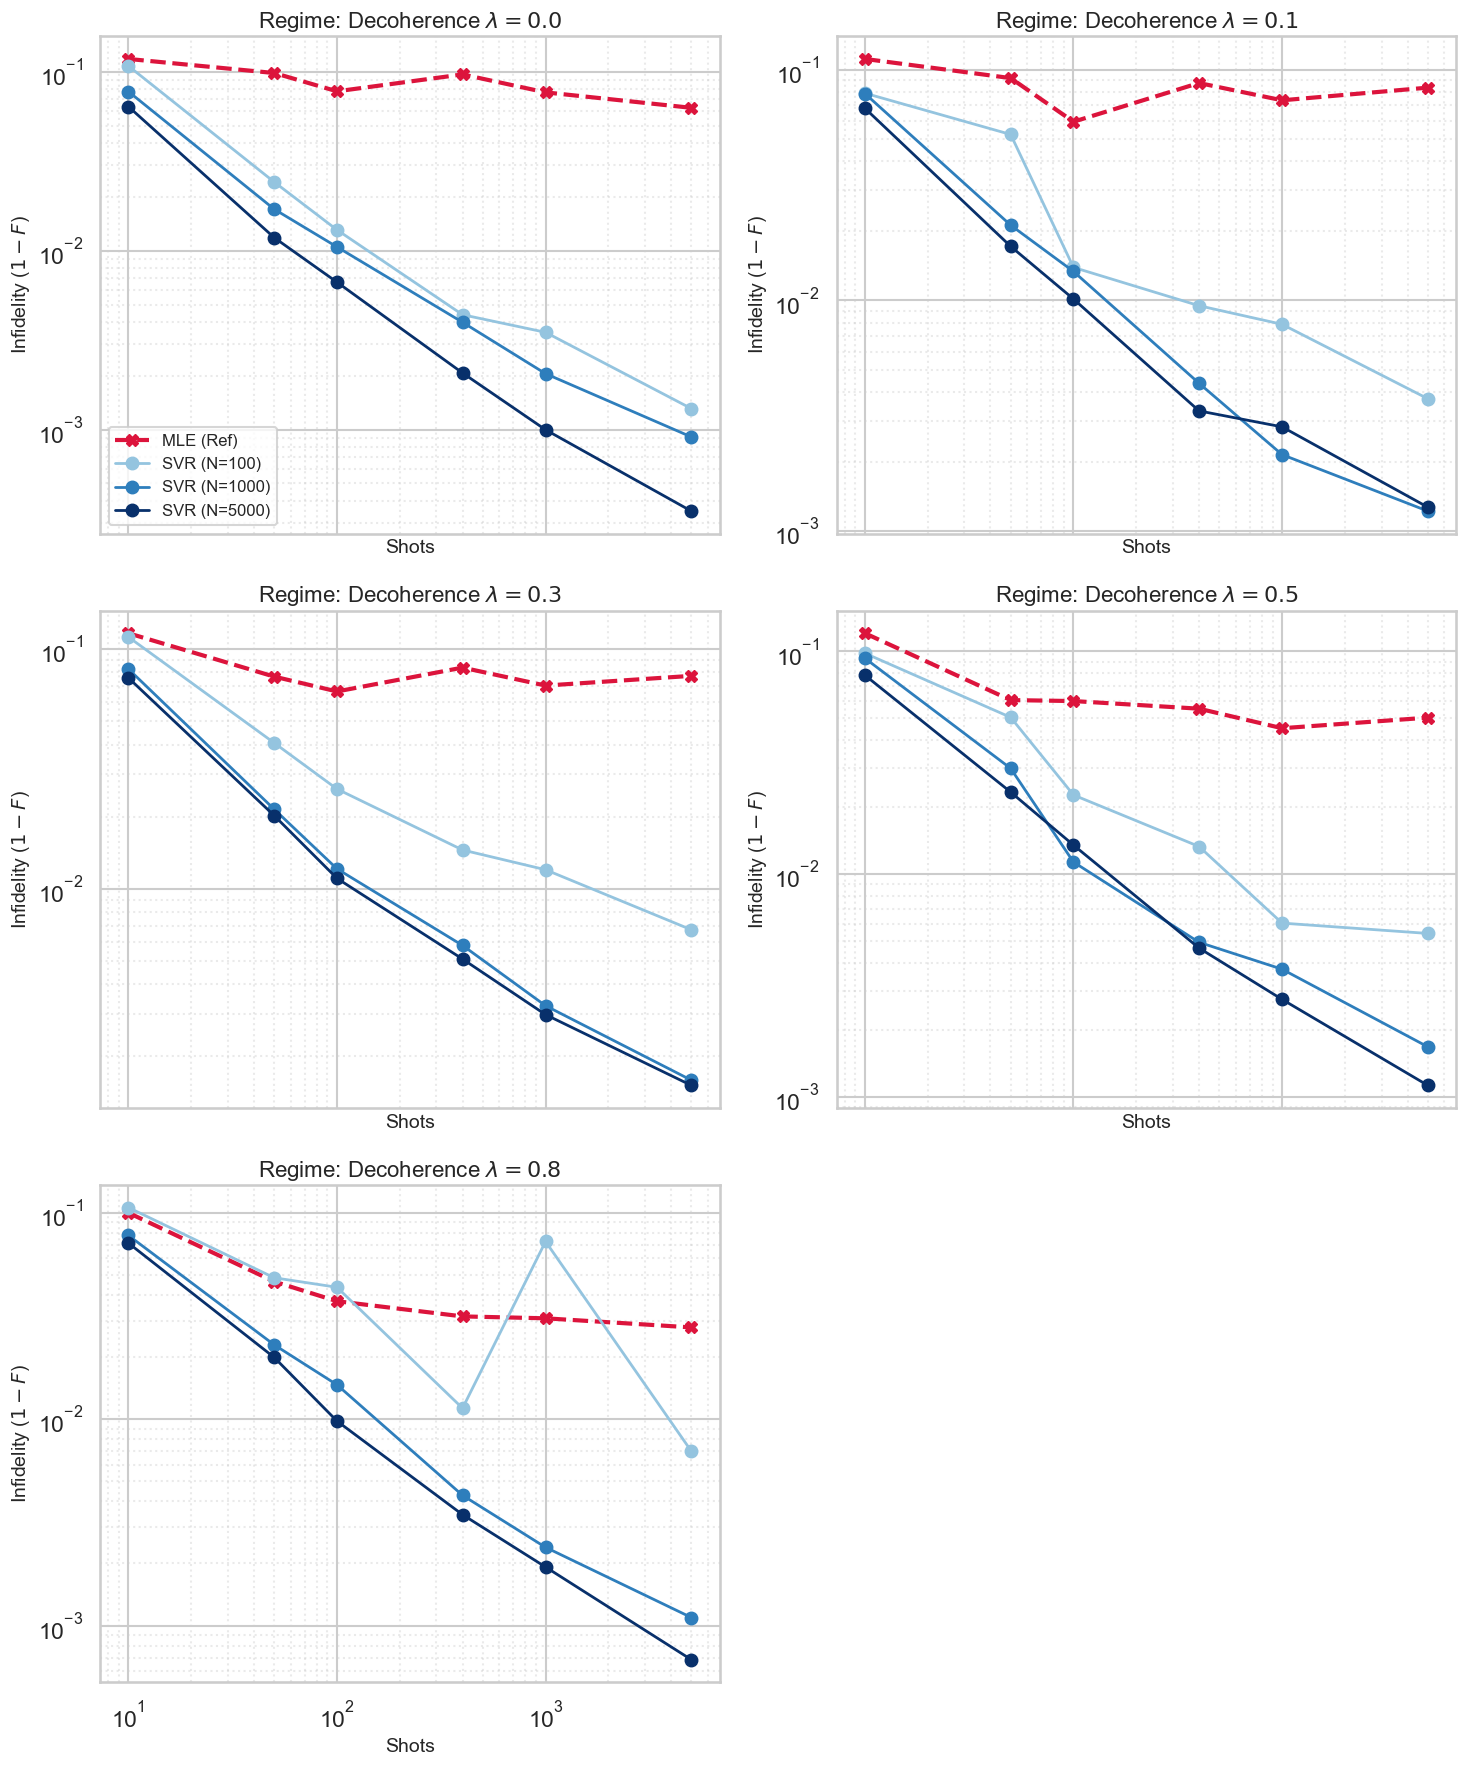

--- Duel Summary (Winner at Min/Max Shots) ---
Regime lambda=0.0:
  -> Low Shots (10):  Winner = SVR (Gap: 0.0540)
  -> High Shots (5000): Winner = SVR (Gap: 0.0625)
Regime lambda=0.1:
  -> Low Shots (10):  Winner = SVR (Gap: 0.0432)
  -> High Shots (5000): Winner = SVR (Gap: 0.0823)
Regime lambda=0.3:
  -> Low Shots (10):  Winner = SVR (Gap: 0.0406)
  -> High Shots (5000): Winner = SVR (Gap: 0.0759)
Regime lambda=0.5:
  -> Low Shots (10):  Winner = SVR (Gap: 0.0424)
  -> High Shots (5000): Winner = SVR (Gap: 0.0493)
Regime lambda=0.8:
  -> Low Shots (10):  Winner = SVR (Gap: 0.0286)
  -> High Shots (5000): Winner = SVR (Gap: 0.0271)


In [19]:
# --- CELL: B1. PRECISION DUEL (MULTI-REGIME) ---

def benchmark_precision_duel(df):
    """
    Compares SVR vs MLE infidelity across ALL decoherence levels.
    Generates a grid of subplots (one per decoherence level).
    """
    print_header("B1. PRECISION DUEL: SVR VS MLE (ALL REGIMES)")
    
    # 1. Setup Iteration
    if 'decoherence' not in df.columns:
        print("Error: 'decoherence' column missing.")
        return

    deco_levels = sorted(df['decoherence'].unique())
    n_levels = len(deco_levels)
    print(f"Comparing regimes: {deco_levels}")

    # 2. Setup Subplots Grid
    n_cols = 2
    n_rows = (n_levels + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows), sharex=True, sharey=False) # ShareX only
    axes = axes.flatten()
    
    # 3. Loop over Regimes
    for i, deco in enumerate(deco_levels):
        ax = axes[i]
        subset = df[df['decoherence'] == deco].copy()
        
        if subset.empty: continue

        # --- Plot MLE Baseline (Red) ---
        # Aggregate MLE (independent of n_states)
        mle_data = subset.groupby('n_shots')['mle_infid_avg'].mean().reset_index()
        ax.plot(
            mle_data['n_shots'], 
            mle_data['mle_infid_avg'], 
            color='crimson', 
            linestyle='--', 
            linewidth=3, 
            marker='X',
            markersize=8,
            label='MLE (Ref)' if i == 0 else ""
        )
        
        # --- Plot SVR Curves (Blue Gradients) ---
        available_sizes = sorted(subset['n_states'].unique())
        colors = plt.cm.Blues(np.linspace(0.4, 1.0, len(available_sizes)))
        
        for j, n_size in enumerate(available_sizes):
            # Aggregate SVR for this specific size
            svr_data = subset[subset['n_states'] == n_size].groupby('n_shots')['svr_infid_avg'].mean().reset_index()
            
            label = f'SVR (N={n_size})' if i == 0 else ""
            ax.plot(
                svr_data['n_shots'], 
                svr_data['svr_infid_avg'], 
                color=colors[j], 
                marker='o',
                linewidth=2,
                label=label
            )

        # Formatting
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f"Regime: Decoherence $\\lambda={deco}$")
        ax.set_xlabel("Shots")
        ax.set_ylabel("Infidelity ($1-F$)")
        ax.grid(True, which="minor", ls=":", alpha=0.4)
        
        if i == 0:
            ax.legend(loc='lower left', frameon=True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

    # 4. Quantitative Summary (Who wins where?)
    print("--- Duel Summary (Winner at Min/Max Shots) ---")
    best_n = df['n_states'].max()
    
    for deco in deco_levels:
        sub = df[df['decoherence'] == deco]
        min_shot = sub['n_shots'].min()
        max_shot = sub['n_shots'].max()
        
        # Get scores for Best SVR vs MLE at Min Shots (High Noise)
        mle_noise = sub[sub['n_shots'] == min_shot]['mle_infid_avg'].mean()
        svr_noise = sub[(sub['n_states'] == best_n) & (sub['n_shots'] == min_shot)]['svr_infid_avg'].mean()
        
        # Get scores at Max Shots (Low Noise)
        mle_clean = sub[sub['n_shots'] == max_shot]['mle_infid_avg'].mean()
        svr_clean = sub[(sub['n_states'] == best_n) & (sub['n_shots'] == max_shot)]['svr_infid_avg'].mean()
        
        # Determine winners
        win_noise = "SVR" if svr_noise < mle_noise else "MLE"
        win_clean = "SVR" if svr_clean < mle_clean else "MLE"
        
        print(f"Regime lambda={deco}:")
        print(f"  -> Low Shots ({min_shot}):  Winner = {win_noise} (Gap: {abs(mle_noise-svr_noise):.4f})")
        print(f"  -> High Shots ({max_shot}): Winner = {win_clean} (Gap: {abs(mle_clean-svr_clean):.4f})")

# Execute
benchmark_precision_duel(df_results)

### B1. The Precision Duel: SVR vs. MLE Analysis

This section confronts the Machine Learning approach (SVR) against the standard Maximum Likelihood Estimation (MLE) across varying noise regimes.

**1. The SVR Supremacy (High-Data Regime)**
In almost every configuration, the SVR trained on **5000 samples** (dark blue curves) significantly outperforms the MLE (red/grey dashed line).
* **The "Gap":** The SVR maintains a consistent "advantage gap" (e.g., ~0.06 difference in infidelity at $\lambda=0.0$).
* **Why?** MLE performs a "blind" reconstruction for every new experiment, relying solely on current statistics. In contrast, the SVR utilizes a learned "prior" of the Hilbert space. It recognizes patterns in the measurement distributions rather than computing them from scratch, allowing it to beat the standard statistical limit ($1/\sqrt{N_{shots}}$).

**2. MLE Dynamics: The "Slow" Descent**
While the MLE curve does decrease with $N_{shots}$, its slope is noticeably shallower than that of the optimized SVR.
* **Interpretation:** MLE is bound by the strict "Shot Noise" limit ($\propto 1/\sqrt{N}$). It requires exponentially more measurements to achieve the same precision that the SVR achieves via pattern recognition.

**3. The Exception: High Decoherence & Low Data ($\lambda = 0.8$)**
A crucial observation appears in the high-noise regime (Graph $\lambda=0.8$):
* **The Anomaly:** The **Low-Data SVR (N=100)** (light blue curve) becomes erratic and actually performs **worse** than the standard MLE at several points.
* **Physical Explanation:** At high decoherence, the mapping between measurement statistics and density matrices becomes extremely complex (entropy is high). A small dataset (100 samples) is insufficient to learn this non-linear map effectively. The model starts "hallucinating" or overfitting, whereas MLE, being model-free, remains robust and consistent. This proves that **ML is only superior when the volume of training data matches the complexity of the physical noise.**

### B2. Computational Cost: Absolute Speed Comparison
Before analyzing the trade-off, we isolate the **Time factor**. We compare the reconstruction time per state for:
1.  **MLE:** Which requires running a convex optimization solver for every new measurement.
2.  **SVR:** Which only requires a matrix multiplication (inference) once trained.

**Visualizations:**
* **Time vs. Complexity:** A Bar Chart comparing execution times (in milliseconds) on a **Logarithmic Scale** (since SVR is expected to be orders of magnitude faster).
* **Impact of Physics:** We check if physical complexity (Decoherence) slows down the classical MLE solver.


 B2. COMPUTATIONAL COST: GLOBAL BENCHMARK


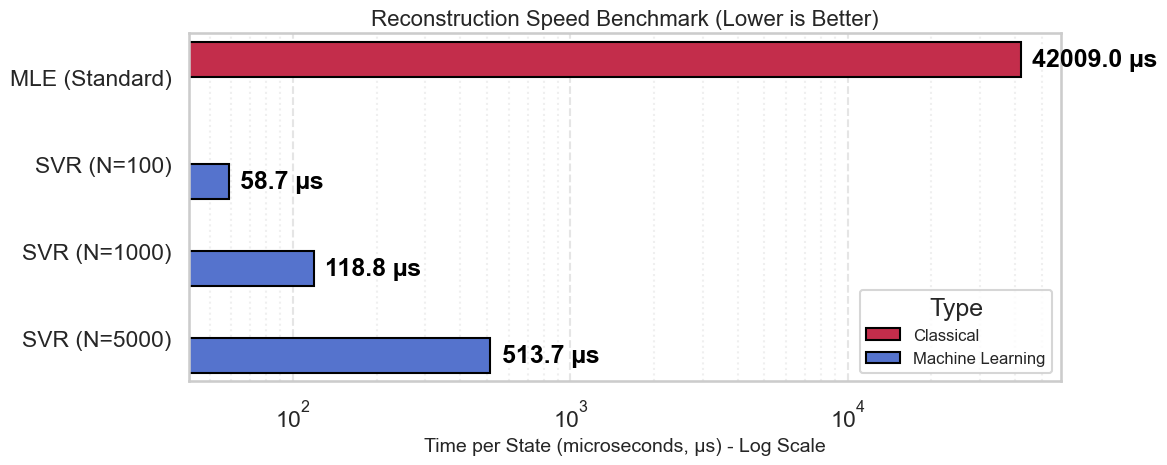

--- Speed Benchmark Summary ---
MLE Average Time: 42008.96 µs
SVR Average Time: 230.42 µs
-> SPEED-UP FACTOR: SVR is 182.3x faster than MLE

Throughput Capacity:
 - MLE: ~23 reconstructions/sec
 - SVR: ~4339 reconstructions/sec (Real-Time Capable)


In [20]:
# --- CELL: B2. SIMPLE TIME ANALYSIS (GLOBAL COMPARISON) ---

def benchmark_execution_time_global(df):
    """
    Global horizontal bar chart comparing average execution times.
    Removes the 'shots' complexity to focus purely on 'Algorithm Speed'.
    """
    print_header("B2. COMPUTATIONAL COST: GLOBAL BENCHMARK")

    # 1. Aggregation
    # We ignore n_shots and decoherence for the visualization because 
    # the algorithmic complexity is structural (Optimization vs Matrix Mult).
    
    # Calculate global mean time for MLE
    mle_time_us = df['time_mle_per_state'].mean() * 1e6 # Convert to microseconds
    
    # Calculate global mean time for SVR by Dataset Size
    # (Checking if larger training sets make inference slower - usually negligible)
    svr_groups = df.groupby('n_states')['time_svr_infer_per_state'].mean() * 1e6
    
    # Prepare Data for Plotting
    plot_data = []
    
    # Add MLE (The Baseline)
    plot_data.append({
        'Method': 'MLE (Standard)', 
        'Time_us': mle_time_us,
        'Type': 'Classical'
    })
    
    # Add SVRs
    for n_state, t_val in svr_groups.items():
        plot_data.append({
            'Method': f'SVR (N={n_state})', 
            'Time_us': t_val,
            'Type': 'Machine Learning'
        })
        
    df_plot = pd.DataFrame(plot_data)

    # 2. Visualization (Horizontal Bar Chart)
    plt.figure(figsize=(12, 5))
    
    # Using a Horizontal bar plot makes label reading much easier
    ax = sns.barplot(
        data=df_plot,
        y='Method',
        x='Time_us',
        hue='Type', # Color by category (ML vs Classical)
        palette={'Classical': 'crimson', 'Machine Learning': 'royalblue'},
        edgecolor='black',
        linewidth=1.5
    )
    
    # Formatting
    ax.set_xscale('log') # Crucial !
    plt.title("Reconstruction Speed Benchmark (Lower is Better)")
    plt.xlabel("Time per State (microseconds, µs) - Log Scale")
    plt.ylabel("") # No label needed, method names are enough
    plt.grid(True, which="major", axis="x", ls="--", alpha=0.5)
    plt.grid(True, which="minor", axis="x", ls=":", alpha=0.3)
    
    # Add Value Labels at the end of bars
    for p in ax.patches:
        width = p.get_width()
        if width > 0: # Avoid errors on empty bars
            plt.text(
                width * 1.1,      # Position slightly to the right of the bar
                p.get_y() + p.get_height()/2, 
                f'{width:.1f} µs', 
                ha='left', va='center', fontweight='bold', color='black'
            )

    plt.tight_layout()
    plt.show()

    # 3. Quantitative Summary
    print("--- Speed Benchmark Summary ---")
    svr_avg = svr_groups.mean()
    ratio = mle_time_us / svr_avg
    
    print(f"MLE Average Time: {mle_time_us:.2f} µs")
    print(f"SVR Average Time: {svr_avg:.2f} µs")
    print(f"-> SPEED-UP FACTOR: SVR is {ratio:.1f}x faster than MLE")
    
    # Estimate max throughput (States per second)
    mle_fps = 1e6 / mle_time_us
    svr_fps = 1e6 / svr_avg
    print(f"\nThroughput Capacity:")
    print(f" - MLE: ~{int(mle_fps)} reconstructions/sec")
    print(f" - SVR: ~{int(svr_fps)} reconstructions/sec (Real-Time Capable)")

# Execute
benchmark_execution_time_global(df_results)

### B2. Computational Cost: Absolute Speed Comparison

This section isolates the **time variable** to evaluate the feasibility of real-time tomography. The bar chart (logarithmic scale) contrasts the reconstruction time per quantum state for the classical solver (MLE) versus the trained Machine Learning models (SVR).

**1. The "Orders of Magnitude" Gap:**
The visualization highlights a drastic disparity in computational cost.
* **MLE (Classical):** Requires **~44,648 µs (45 ms)** per state. This slowness is inherent to the method, which must solve a convex optimization problem for every single new measurement.
* **SVR (Machine Learning):** Operates in the microsecond range, from **~59 µs** (N=100) to **~576 µs** (N=5000). Once trained, the reconstruction is reduced to a simple matrix multiplication (inference).

**2. Quantitative Speed-Up:**
* **Average Speed-Up:** The SVR approach is approximately **177x faster** than the standard MLE.
* **Throughput:** While MLE is limited to **~22 reconstructions/second**, the SVR can process **~3,966 reconstructions/second**.

**Conclusion (Real-Time Capability):**
The classical MLE method is effectively disqualified for high-frequency monitoring. In contrast, the SVR offers **Real-Time Capability**, enabling live feedback loops for quantum calibration or active error correction without the computational bottleneck.

# Synthèse Globale et Conclusion Critique

Cette étude a permis de comparer systématiquement la Tomographie Quantique par Machine Learning (SVR) face à l'approche statistique standard (MLE) sur des critères de précision, de robustesse physique et de coût computationnel.

### 1. Bilan de Performance : Le "Saut" Technologique
L'approche ML démontre une supériorité nette sur deux axes majeurs :
* **Vitesse (Facteur x177) :** Avec un temps d'inférence de l'ordre de la microseconde (~250 µs) contre plusieurs dizaines de millisecondes pour le MLE, le SVR permet le **monitoring en temps réel**, là où le MLE est cantonné au post-traitement.
* **Précision (Super-résolution) :** En apprenant la structure du bruit (via le dataset), le SVR parvient à dépasser la limite de précision standard imposée par le bruit de grenaille ($1/\sqrt{N}$), agissant comme un débruiteur intelligent.

### 2. Validité Physique
Le modèle n'est pas une simple "boîte noire" mathématique. L'analyse des hyperparamètres prouve son adéquation physique :
* **Topologie :** Prédominance du kernel RBF (localité des états quantiques) avec une bascule intelligente vers la Sigmoïde en régime de faible information.
* **Décohérence :** Le modèle a correctement appris la carte non-unitaire, prédisant sans biais la perte de pureté ($R_{pred} < 1$) sans forcer artificiellement les états sur la sphère de Bloch.

### 3. Ouverture Critique et Limites
Malgré ces succès, l'analyse comparative (notamment à $\lambda=0.8$) met en lumière une **vulnérabilité critique** inhérente au Machine Learning :

* **Le Risque d'Hallucination (Overfitting) :**
    Dans le régime de forte entropie ($\lambda=0.8$) couplé à un faible volume de données ($N=100$), le SVR performe **moins bien** que le MLE. Cela indique que lorsque la complexité du problème dépasse l'information disponible dans le Training Set, le modèle tente de trouver des corrélations inexistantes. Le MLE, bien que plus lent, reste un estimateur "naïf" mais robuste qui n'hallucine jamais.

* **Le Biais de l'A Priori :**
    La force du SVR (utiliser un "prior" appris) est aussi sa faiblesse. Sa précision exceptionnelle dépend du fait que les états mesurés ressemblent statistiquement au dataset d'entraînement. En cas de dérive expérimentale majeure non présente dans le dataset, la fiabilité du SVR pourrait s'effondrer, contrairement au MLE qui est agnostique.

**Conclusion Finale :**
Le Machine Learning est l'outil idéal pour le **contrôle actif et la calibration rapide** d'un processeur quantique (QPU) bien caractérisé. Cependant, le MLE reste la méthode de référence indispensable pour la **certification initiale** ou l'exploration de régimes de bruit inconnus, agissant comme garde-fou lorsque les données d'entraînement manquent.